In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

from mpl_toolkits.mplot3d import Axes3D

# plt.switch_backend('qt5agg')

# Initial Conditions and Definitions
#### Follows from example 3.4.1 in Ye

In [2]:
T = 40

# Income at time t, should be i(t)
def y(t):
    return 50000*np.exp(.03*t)

# Non-risky Investment rate
r = .04

# Continuous process (think average return rate of risky investment)
mu = .09

# Standard deviation of risky investment
sigma = .18

# Utility discount rate
rho = .03

# Hazard Function (probability of death at this moment in time)
def lamb(t):
    return 1/200 + 9/8000*t

# Insurance premium-payout ratio
def eta(t):
    return 1/200 + 9/8000*t

# Relative risk aversion
gamma = -3

# Direct Solution
### Requires a few more function definitions

In [3]:
def integral(f, t0, tf):
    # f is a function
    return quad(f, t0, tf)[0]

# Integral function doesn't play nice with sums of constants and functions
def sum_r(t):
    return r+eta(t)
def sum_rho(t):
    return lamb(t)+rho

def H(v):
    return sum_rho(v)/(1-gamma) - .5*gamma*((mu-r)/((1-gamma)*sigma))**2 - \
                                gamma/(1-gamma)*sum_r(v)

def K(s):
    return (lamb(s)**(1/(1-gamma)))/eta(s)**(gamma/(1-gamma)) + 1

def e(t):
    return np.exp(-integral(H,t,T)) + integral(lambda s: np.exp(-integral(H,t,s))*K(s),t,T)
    
def a(t):
    return np.exp(-rho*t)*e(t)**(1-gamma)

def b(t):
    return integral(lambda s: y(s)*np.exp(-integral(sum_r,t,s)),t,T)

def c(t):
    return (1/e(t))*(x+b(t))

def D(t):
    return (lamb(t)/eta(t))**(1/(1-gamma))*1/e(t)

def Z(t):
    return D(t)*(x+b(t))

def theta(t):
    return ((mu-r)/((1-gamma)*sigma**2))*(x+b(t))

def p(t):
    return eta(t)*((D(t)-1)*x+D(t)*b(t))

In [4]:
def V(t,x):
    return a(t)/gamma*(x+b(t))**gamma

In [ ]:
time, x = np.meshgrid(np.linspace(0,40,401),np.linspace(0,3000000,51)-1100000) #-b(0))

In [ ]:
# b(0)~1200000, use 1100000 for graphing purposes
moneys = np.linspace(0,3000000,51)-1100000
times = np.linspace(0,40,400)
Happy = np.zeros((len(moneys),len(times)))

for i in range(len(moneys)):
    for j in range(len(times)):
        Happy[i,j] = V(times[j],moneys[i])

In [ ]:
Moneys, Times = np.meshgrid(moneys+1100000, times)

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(Moneys, Times, Happy.T)
plt.show()

# The Finite Difference Approach

In [5]:
import scipy.optimize as opt

In [6]:
# These utility definitions come in 4.3, pg 69
# Utility of consumption c 
def U(c,t):
    return np.exp(-rho*t)/gamma * c**gamma

# Utility of bequeathance Z, if dead early
def B(Z,t):
    return np.exp(-rho*t)/gamma * Z**gamma

# Utility of wealth remaining after T
def L(x,T):
    return np.exp(-rho*T)/gamma * x**gamma

### This approach will consume too much memory. Iterating recursively we will reuse too many values.

In [7]:
# These are the 'Transition Probabilities' on pg 68.
# 3 fumctions are created for ease of substitution
# Because there is no dependence on u, I will just make them functions of t, theta_hat, c_hat, Z_hat for optimization

def Pplus(theta_hat,t):
    return delta/h*(r+eta(t)+theta_hat*(mu-r)) + (delta/(2*h**2))*(sigma**2)*(theta_hat**2)

def Pminus(theta_hat, c_hat, Z_hat, t):
    return (delta/(2*h**2))*(sigma**2)*(theta_hat**2) + (delta/(2*h))*(sigma**2)*(theta_hat**2) + (delta/h)*(c_hat+eta(t)*Z_hat)

def P(theta_hat, c_hat, Z_hat, t):
    return 1-Pplus(theta_hat,t)-Pminus(theta_hat, c_hat, Z_hat, t)

# Think of a means to save V_hat values to avoid repetition, significantly reduce the # of computations
def V_hat(t, u, T):
    # This will be a recursive function. It should terminate at t=T
    if t==T:
        return L(np.exp(u),T)
    return None
    
#     # These bounds are determined in (4.5) on pg 68
#     bounds = ((None,None), (0,None), (1-np.exp(-u)*b(t),None))
    
#     # The guess for theta-hat is .3, since that is about what we saw in Figure 9 on pg 61 for the closed form solution.
#     guess = (.3,.1,1-np.exp(u)*b(t))
#     f = lambda theta_hat, c_hat, Z_hat: \
#             -Pplus(theta_hat,t)*V_hat(t+delta,u+h,T) +\
#             -P(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u,T) +\
#             -Pminus(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u-h,T) +\
#             -delta*lamb(t)*B(np.exp(u)*Z_hat,t) +\
#             -delta*U(np.exp(u)*c_hat,t)
    
#     v_hat = opt.minimize(f,guess,bounds=bounds).fun
#     return -1/(1+delta*lamb(t))*v_hat

### Instead, we know what's supposed to happen at the boundary, $V(T,u)=L(e^u)$, so start at $t=T$ and work back to $t_0$.

In [218]:
u_ = 14 # This is the u that we are interestedf in for comparison purposes
v_ = -5 # This is another value of u to test

T = 40 # represents the final time
u_min = np.round(np.log(3e-7)) # starting u at t=0, u~-15
u_max = np.round(np.log(3e6)) # ending u at t=0, u~15

# Some success with delta = .0005, h = .01

delta = .001 # time step, changed from .01
h = .02 # wealth (u) step, changed from .02

diff_0 = u_max - u_min
u_0 = np.linspace(u_min, u_max, int(diff_0/h)+1) # array of u values at t=0

steps = T/delta*h

u_min -= steps # new starting u at t=T, u~-95 if delta = .01, u~-815 if delta = .001
u_max += steps # new ending u at t=T, u~95 if delta = .01, u~815 if delta = .001

diff = u_max-u_min

u_new = np.linspace(u_min, u_max, int(diff/h)+1) # array of u values at t=T

In [243]:
u_ref = int((u_ - u_min)/h) # This is the index of the u we are interested
v_ref = int((v_ - u_min)/h)

u_first = int((u_0[0] - u_min)/h)

start = v_ref
end = -u_first

In [244]:
# Define the optimized happiness V at t=T
V_T = L(np.exp(u_new),T)

C:\Users\Joey\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\Users\Joey\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':
C:\Users\Joey\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in power
  if sys.path[0] == '':


# Constrained Version

In [245]:
# Next we want to move backward one step in time from T to T-delta, using the iterative process in 4.5
t = T - delta

# These bounds are determined in (4.5) on pg 68, will be used in the optimize function
Z_bound = 1-np.exp(-u_new)*b(t)
# bounds = ((None,None), (0,None), (1-np.exp(u)*b(t),None))

# Introduce a multiplier. The V values are small, of magnitude -6 - -20, so the optimizer doesn't catch these values and can't 
multiplier = 1e-1

# Define the function to minimize with parameters strictly in theta_hat, c_hat, Z_hat
def f(params, u, t, T, sign=1.0):
    theta_hat, c_hat, Z_hat = params
    return multiplier*-1*1/(1+delta*lamb(t))* \
        (Pplus(theta_hat,t)*V_hat(t+delta,u+h,T) +\
        P(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u,T) +\
        Pminus(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u-h,T) +\
        delta*lamb(t)*B(np.exp(u)*Z_hat,t) +\
        delta*U(np.exp(u)*c_hat,t))

cons = ({'type': 'ineq', 'fun': lambda x: Pplus(x[0], t)},
        {'type': 'ineq', 'fun': lambda x: Pminus(x[0], x[1], x[2], t)},
        {'type': 'ineq', 'fun': lambda x: P(x[0], x[1], x[2], t)})

sol = [opt.minimize(f, x0 = (.3,.7,1-np.exp(-u)*b(t)), args=(u, t, T), constraints=cons,
                  bounds = ((0,None), (0,None), (1-np.exp(-u)*b(t),None))) for u in u_new[start:end]]
V_T_1 = [-s.fun/multiplier for s in sol]
V_T_1_params = [s.x for s in sol]

C:\Users\Joey\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\Users\Joey\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """


In [246]:
theta_hat, c_hat, Z_hat = V_T_1_params[0]
print(Pplus(theta_hat,t))
print(Pminus(theta_hat,c_hat,Z_hat,t))
print(P(theta_hat,c_hat,Z_hat,t))

0.999999999359
-8.56539950078e-10
1.49764600721e-09


In [247]:
def V_tilda(t,w):
    return a(t)/gamma*(w)**gamma

def V_hat_exact(t,u):
    return a(t)/gamma*np.exp(u)**gamma

V_exact = V_hat_exact(t, u_new[start:end])

In [248]:
print(len(V_exact))
print(V_exact[:10])

1001
[-329468.74461965 -310281.97860733 -292212.56286275 -275195.42797181
 -259169.29386841 -244076.44915935 -229862.54330147 -216476.39088081
 -203869.78728988 -191997.33513892]


In [249]:
print(len(V_T_1))
print(V_T_1[:10])

1001
[-309074.5267495659, -291075.42753188696, -274124.50773167476, -258160.74530629077, -243126.63388965002, -228968.0409697509, -215633.9803097734, -203076.43488569834, -191250.18404312554, -180112.64031772665]


In [250]:
V_T_1_params[:10]

[array([  4.92707901e+00,   1.20792598e+03,  -2.45602106e+04]),
 array([  4.92707902e+00,   1.18351182e+03,  -2.40719165e+04]),
 array([  4.92707965e+00,   1.15957238e+03,  -2.35931170e+04]),
 array([  4.92707901e+00,   1.13610014e+03,  -2.31236614e+04]),
 array([  4.92707902e+00,   1.11308242e+03,  -2.26632967e+04]),
 array([  4.92707902e+00,   1.09050715e+03,  -2.22117812e+04]),
 array([  4.92707902e+00,   1.06836152e+03,  -2.17688586e+04]),
 array([  4.92707901e+00,   1.04663079e+03,  -2.13342343e+04]),
 array([  4.92707904e+00,   1.02530296e+03,  -2.09076680e+04]),
 array([  4.92707902e+00,   1.00461467e+03,  -2.04938929e+04])]

# Unconstrained Version

In [239]:
# Next we want to move backward one step in time from T to T-delta, using the iterative process in 4.5
t = T - delta

# These bounds are determined in (4.5) on pg 68, will be used in the optimize function
Z_bound = 1-np.exp(-u_new)*b(t)
# bounds = ((None,None), (0,None), (1-np.exp(u)*b(t),None))

multiplier = 1e21
# Define the function to minimize with parameters strictly in theta_hat, c_hat, Z_hat
def f(params, u, t, T, sign=1.0):
    theta_hat, c_hat, Z_hat = params
    return multiplier*-1/(1+delta*lamb(t))* \
        (Pplus(theta_hat,t)*V_hat(t+delta,u+h,T) +\
        P(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u,T) +\
        Pminus(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u-h,T) +\
        delta*lamb(t)*B(np.exp(u)*Z_hat,t) +\
        delta*U(np.exp(u)*c_hat,t))

cons = ({'type': 'ineq', 'fun': lambda x: Pplus(x[0], t)},
        {'type': 'ineq', 'fun': lambda x: Pminus(x[0], x[1], x[2], t)},
        {'type': 'ineq', 'fun': lambda x: P(x[0], x[1], x[2], t)})

sol = [opt.minimize(f, x0 = (.3,.9,1-np.exp(-u)*b(t)), args=(u, t, T), constraints=cons,
                  bounds = ((0,1), (0,1), (None,None))) for u in u_new[start:end]]
V_T_1 = [-s.fun/multiplier for s in sol]
V_T_1_params = [s.x for s in sol]

C:\Users\Joey\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\Users\Joey\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """


In [240]:
print(Z_bound[start:start+10])
V_T_1_params[:10]

[ 0.99986197  0.9998647   0.99986738  0.99987001  0.99987258  0.9998751
  0.99987758  0.99988     0.99988238  0.99988471]


[array([ 0.37313998,  0.9932704 ,  0.98898213]),
 array([ 0.37294034,  0.99357892,  0.98897335]),
 array([ 0.3727779 ,  0.99367217,  0.9889767 ]),
 array([ 0.37257036,  0.99383052,  0.98896591]),
 array([ 0.37222385,  0.99270806,  0.98911481]),
 array([ 0.3725862 ,  0.99284512,  0.98903425]),
 array([ 0.37298009,  0.99307257,  0.9889199 ]),
 array([ 0.37319349,  0.9933952 ,  0.98883377]),
 array([ 0.3732122 ,  0.99377065,  0.98880972]),
 array([ 0.37234152,  0.99270449,  0.98901711])]

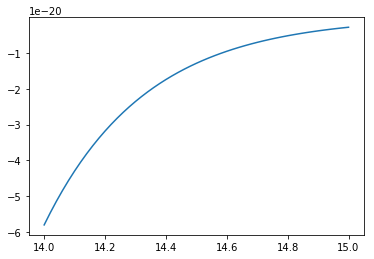

In [241]:
plt.plot(u_new[start:end], V_T_1)
plt.show()

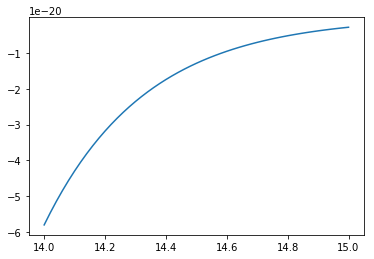

In [242]:
plt.plot(u_new[start:end], V_exact)
plt.show()

In [252]:
1/e(t)

0.99904569061882942